# AsteroGaP: A Guide 

Dear user/reader, 

I have so much to tell you. In this notebook I will be going through and explaining how to use our code, and how the code itself functions. I'll try my best to explain everything as clearly as possible and delve into details, so feel free to skip around if there are parts that interest you more than others.

But first, a quick look at the what motivated us to develop this code.

## Motivation

The motivation for this code stems from a drive to incorporate new computational methods with new astronomical problems. 

Asteroids are leftover remnents from the creation of the solar system. As they orbit the Sun, they also rotate along an axis. This rotation makes it so that the light reflected and measured off an asteroid will vary with time, meaning if we monitor the asteriod for long enough, we will be able to measure a complete rotation and figure out what the asteroid's rotational period is (an example lightcurve is plotted in the cell below). This rotational period tells us a long about that the asteroid might be made off and how we can expect it to behave in the future.

Traditionally, these rotational periods were measured by training a telescope on an asteroid for several hours, and observing as frequently as possible so that you could see the lightcurve.

Text(0.5, 1.0, 'Phaethon 3200')

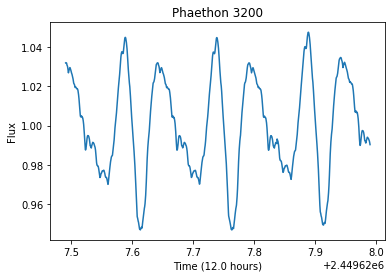

In [3]:
# import packages to run
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# find a way to include or fetch this data
filename = "../../../CometGPs/data/paper_plots/3200/3200_lc_49627_to_49787.txt"

data = pd.read_csv(filename, delim_whitespace=True, header=None)

time = data[0]
flux = data[1]

x = 1440 # 12 hours, every index is 30 seconds

plt.plot(time[0: x], flux[0: x])
plt.xlabel("Time (%.1f hours)"%(x*0.5/60))
plt.ylabel("Flux")
plt.title("Phaethon 3200")


Currently (as of 2020) we are seeing a slew of new survey telescopes being developed (e.g. LSST), intended for all-sky coverage. While these telescopes are great for developing time-series data, their expansive field makes it so that the same objects are only photographed every couple of nights. Rather than looking like the asteroid above, it would instead look sparse, like the following plot, if it was only observed every 12 hours for a month.

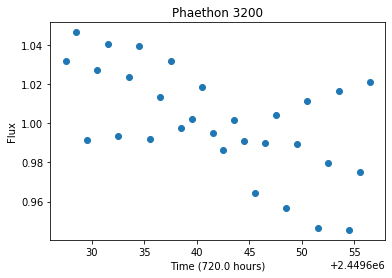

In [4]:
x = 1440*2*30 # 30 days

plt.plot(time[0: x: 2880], flux[0: x: 2880], "o")
plt.xlabel("Time (%.1f hours)"%(x*0.5/60))
plt.ylabel("Flux")
plt.title("Phaethon 3200")
plt.show()

Visually, it's a nearly impossible to guess what the rotational period should be, and even Lomb-Scargle Periodograms sometimes have a hard time determining what the period might be if the lightcurve is sparse enough. 

It was with these sparse incoming datasets in mind that we decided to develop this method, lovingly named AsteroGaP for **Astero**id **Ga**ussian **P**rocesses.

## Gaussian Processes

You might at this point be wondering, what are Gaussian Processes (GP)? A Gaussian Process (also known as Gaussian Process Regression) is a generative kernel-based framework for solving regression problems \citep{Roberts2012}. Rather than modeling the data points directly as in standard linear regression, a Gaussian process models the \textit{covariance} between data points.

Run the following cells to view an interactive visualization of how GP models are fit.

In [5]:
from ipywidgets import interact
import george
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def create_data(gamma = 10, period = 1, amp = 1):
    """
    Generate some periodic data using a periodic kernel.
    """
    
    # generate 10 random numbers for x
    x = 10 * np.sort(np.random.rand(10))
    
    # determine the y error and make it an array as long as x
    # have the error scale with the amplitude
    yerr = 0.2 * amp * np.ones_like(x)
    x_possible = np.linspace(0,10, 1000)

    # create a sinusoidal plot based on inputs
    # establish the kernel type we are using
    kernel = amp * george.kernels.ExpSine2Kernel(gamma, period)
    gp = george.GP(kernel)
    
    # generate a ExpSine2 function using our x-values (0-10) and our y error
    gp.compute(x, yerr)

    # sample the y-values from the function we made
    y_possible = gp.sample(x_possible) # a subset of possible x-values
    
    #return our simulated data with the original function
    return(x_possible, y_possible, gp)

In [7]:
def sample_data(x_possible, y_possible, yerr_amp, random_n=10):
    """
    Samples a n-sized random array of points from the sample data generated in
    the create_data function or another type of light curve sample.
    """
    
    idx = y_possible.size
    
    # randomly select n points from 1-500
    idx_choice = np.random.choice(idx, random_n, replace= False)
    idx_choice.sort()
    
    # filter out the randomly chosen indicies from earlier
    x = x_possible[idx_choice]
    
    # get the predicted y values corresponding to x values
    y_base = y_possible[idx_choice]
    
    # generate some uncertainty
    yerr = yerr_amp * 0.01 * np.ones_like(x) #turn 0.2 into an input (1%)
    
    # add noise to initial y values
    y = y_base + yerr * np.random.randn(len(x))

    return(x, y, yerr)

In [8]:
def plotting_gp_ex(x, y, yerr,pre_y, x_possible, gp):
    """"""
    plt.figure(figsize=(15,10))
    pred, pred_var = gp.predict(y, x_possible, return_var=True)
    plt.fill_between(x_possible, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="red", alpha=0.4)
    plt.plot(x_possible, pred, "red", lw=1.5, alpha=0.7)
    plt.errorbar(x, y, yerr = yerr, fmt="ok", capsize=0, )
    plt.plot(x_possible,pre_y)
    plt.xlim(x_possible.min(), x_possible.max())
    plt.ylim(pre_y.min()-0.5, pre_y.max()+0.5)
    plt.xlabel("x")
    plt.ylabel("y");
    plt.show()

In [9]:
def fit_data(x, y, yerr, gamma, period, gp):
    
    gp.compute(x, yerr)
    x_possible = np.linspace(0,10,500)
    pred, pred_var = gp.predict(y, x_possible, return_var=True)
    ln_likelihood = gp.log_likelihood(y)

    #print(ln_likelihood)

    return gp, ln_likelihood

In [10]:
def data_comparison(gamma, period, amp):
    
    x_pos, py, gp1 = create_data(gamma, period, amp)
    
    def _do_work(n = 10):
        x, y, yerr = sample_data(x_pos, py, 1, n)
    
        gp2, ln_likelihood = fit_data(x, y, yerr, gamma, period, gp1)
        
        plotting_gp_ex(x,y,yerr,py,x_pos,gp2)


    return _do_work

#n will only work if m is set equal to 0

In [12]:
vary_nm = data_comparison(gamma=10, period=np.log(3), amp=1)
interact(vary_nm, n=(2, 20, 2), continuous_update=False)

interactive(children=(IntSlider(value=10, description='n', max=20, min=2, step=2), Output()), _dom_classes=('w…

<function __main__.data_comparison.<locals>._do_work(n=10)>

The code above is perhaps a little complicated to explain now, but the main thing to focus on is this interactive plot down here at the bottom. For the last cell, I have set up a periodic lightcurve in **blue** that repeats every 3 units (the kernel takes the logarithm of the period, hence the log(3) notation), with a gamma of 10, and an amplitude (amp) of 1. Feel free to test out different values for gamma, the period, and the amplitude to get a feel for how the lightcurve changes.

The number **n** in the bar above is the number of **black** observations/samples of the blue lightcurve we are taking. Once we have n number of randomly selected observations (time/x, flux/y, and flux error), we can then feed those samples into a Gaussian Process and see how the model would generate a fit given what it knowns.

As you can hopefully see, with few points, the GP model is only certain with its fit in specific areas (small red shading), and is very uncertain about what happens in other parts of the period (large red shading). The red line is what the predicted fit is, and the shading is the uncertainty. 

If we increase the number of points, the GP model has more information and can make better estimates about what is going in with the lightcurve, reducing the uncertainty. 

Even with just a few observations (~10-20), if the lightcurve has been broadly and evenly sampled, the GP model is able to produce a really great fit for the lightcurve data. 

## Kernels

The main component driving this Gaussian Process model is the kernel, which is a matrix telling the model how the different data points should relate to one another. 

We have specified an Exponential Sine Squared kernel, which is significant because this kernel expects data to repeat after a certain amount of time, like a period. 

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_style("white")
sns.set_palette('viridis')

import numpy as np
import pandas as pd

import george
from george import kernels

<IPython.core.display.Javascript object>


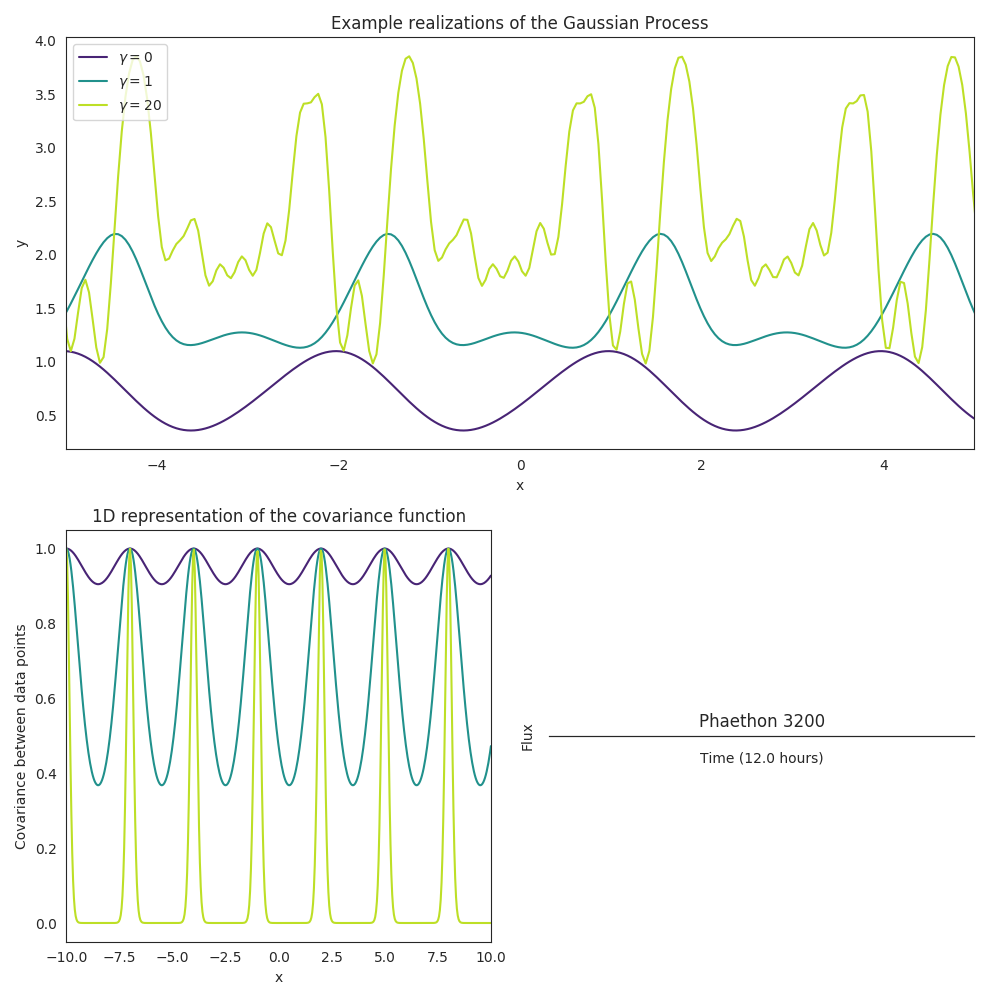

In [17]:
amp = 1.0
log_period = np.log(3.0)
gamma = [0.1, 1.0, 20.0]

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

x = np.linspace(-10, 10, 500)
for i, g in enumerate(gamma):
    kernel = amp * kernels.ExpSine2Kernel(gamma=g, log_period=log_period)
    
    kernel_vals = kernel.get_value(np.atleast_2d(x).T)
    ax2.plot(x, kernel_vals[0],  color=sns.color_palette("viridis", 9)[4*i],
             label=r"$\gamma = %2.f$"%g)
    ax2.set_xlim(x[0], x[-1])
    if i == 1:
        ax3.imshow(kernel_vals, cmap="viridis", interpolation="nearest")
        ax3.set_xticklabels([])
        ax3.set_yticklabels([]);
        ax3.set_title("2D representation of the covariance function")
    
    np.random.seed(1234)
    gp = george.GP(kernel)
    gp.compute(x)
    y = gp.sample(size=1)

    ax1.plot(x, y.T+i, lw=1.5, alpha=1.0, color=sns.color_palette("viridis", 9)[4*i],
             label=r"$\gamma = %2.f$"%g)
    ax1.set_xlim(-5, 5);
    
    
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Example realizations of the Gaussian Process")
ax1.legend(loc=2)

ax2.set_xlabel("x")
ax2.set_ylabel("Covariance between data points")
ax2.set_title("1D representation of the covariance function")

ax3.set_xlabel("x")
ax3.set_ylabel("x")

plt.tight_layout()
#plt.savefig("../paper/fig1.pdf", format='pdf')

### Period

In the image above, we can visualize such a kernel by plotting the distances (which corresponds to time in our data) between data points (x) versus how high their correlation should be. For data points close to one another time wise, we expect their values to be similar, with this similarity getting lower the further away the data points being compared are (take a look at how fast the correlation for the green curve drops in the 1D plot above). The key to this kernel, however, is that after some amount of time, the **Period**, this correlation will jump back up again, and we expect data points to have similar values once again.

### Gamma

The other parameter being visualized here is **Gamma**, often referred to as the inverse of the length-scale. Gamma is simply a measurement of how much variability we expect to see within each period, and how fast we can expect data points to cease correlating with each other. A low value of Gamma means that the intra-period variability should be minor and that data points should remain highly correlated with one another, where as a high Gamma value means that there is a lot of changes happening between each period and data points are not very correlated.

Take a look at the upper plot. We can see 3 different curves modeled, each with the same period but a different value for Gamma. The curve with a Gamma of 0 remains fairly smooth while the curve with a Gamma of 20 varies a lot within each period. The data points from the smooth plot are all pretty similar and are highly correlated. This can be visualized in the lower-left plot, where the purple line shows the correlation for all the data points. Alternatively, the green line shows the correlation for the curve with a high Gamma value, and the correlation essentially drops to 0 inbetween every period. This just means that, even though the curve is expected to repeat itself, there's essentially no telling how a one section of the curve will behave if we only have data for another section.

### Amplitude (periodic)

The **Amplitude** parameter is another part of the kernel but all it really does is scale the height of the curves. A big difference in overall magnitudes for a lightcurve would indicate a large amplitude value, and vice versa.

### Mean

The last parameter assigned to the kernel is the **mean** value. This just determines around which values the fit should be. This mean can either be set to a single value, or another function, but in our case, since we are working with data that has had the phase-angle effect from the sun removed, we can just assume our fits should fall around a single value (often 0 or 1 depending on how the data was normalized)

## Additional Kernel

So it's clear that we expect lightcurves from asteroids to appear periodic, but because of the changing nature of an asteroid's angle to the sun, even though we correct for any major changes in the magnitude, we still expect to see minor changes in the profile in the lightcurve. And indeed, this can be seen even with simulated data after just a couple of months.

The plot below shows what Phaethon's lightcurve looks like at one time versus 2 months later. As you can hopefully see, although the period has remained the same, the lightcurve itself has changed quite a bit.




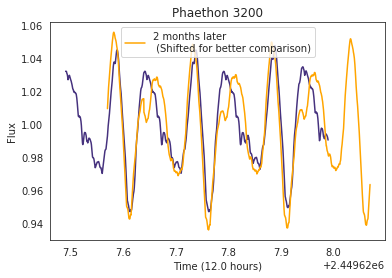

In [49]:
%matplotlib inline

x = 1440 # 12 hours, every index is 30 seconds

plt.plot(time[0: x], flux[0: x])
plt.plot(time[230: 230+x], flux[172800: 172800+x], "orange",label="2 months later\n (Shifted for better comparison)")
plt.xlabel("Time (%.1f hours)"%(x*0.5/60))
plt.ylabel("Flux")
plt.title("Phaethon 3200")
plt.legend()

We wanted to account for this change in the lightcurve in our kernel since that will be used to analyze this data are expected to span many months if not years, and we were worried that a ridgid periodic kernel would not be able to adapt to these subtle changes. We modified our kernel by multiply our basic Exponential Sine Squared kernel with an Exponential Squared kernel. This kernel has been plotted below.

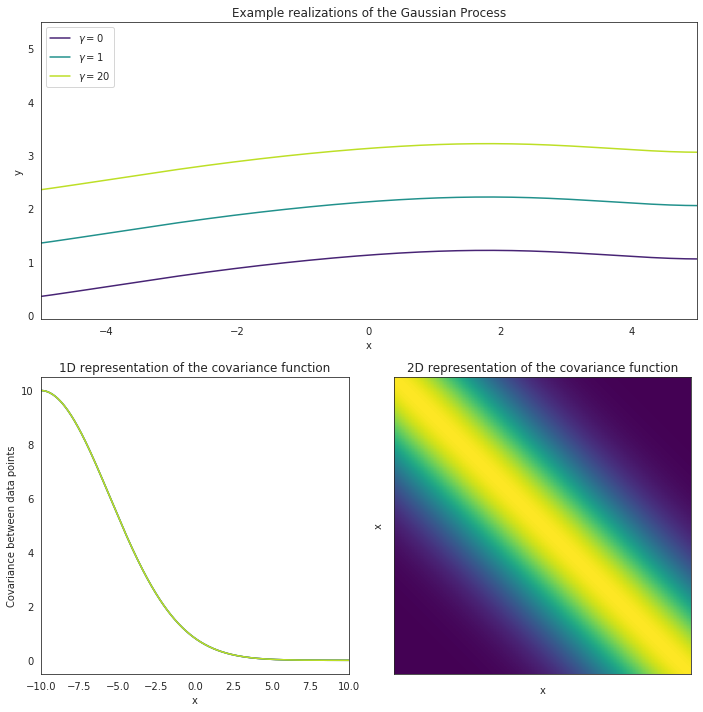

In [51]:
amp_1 = 10.0
metric = 20

amp_2 = 5.0
log_period = np.log(3.0)
gamma = [0.1, 1.0, 20.0]

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

x = np.linspace(-10, 10, 500)
for i, g in enumerate(gamma):
    k1 = amp_1 * kernels.ExpSquaredKernel(metric=metric)
    #k2 = amp_2 * kernels.ExpSine2Kernel(gamma=g, log_period=log_period)
    kernel = k1#*k2 #or k1*k2
    
    kernel_vals = kernel.get_value(np.atleast_2d(x).T)
    ax2.plot(x, kernel_vals[0],  color=sns.color_palette("viridis", 9)[4*i],
             label=r"$\gamma = %2.f$"%g)
    ax2.set_xlim(x[0], x[-1])
    if i == 1:
        ax3.imshow(kernel_vals, cmap="viridis", interpolation="nearest")
        ax3.set_xticklabels([])
        ax3.set_yticklabels([]);
        ax3.set_title("2D representation of the covariance function")
    
    np.random.seed(1234)
    gp = george.GP(kernel)
    gp.compute(x)
    y = gp.sample(size=1)

    ax1.plot(x, y.T+i, lw=1.5, alpha=1.0, color=sns.color_palette("viridis", 9)[4*i],
             label=r"$\gamma = %2.f$"%g)
    ax1.set_xlim(-5, 5);
    
    
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Example realizations of the Gaussian Process")
ax1.legend(loc=2)

ax2.set_xlabel("x")
ax2.set_ylabel("Covariance between data points")
ax2.set_title("1D representation of the covariance function")

ax3.set_xlabel("x")
ax3.set_ylabel("x")

plt.tight_layout()

As you can see, the correlation visualized for this kernel just drops off with distance. This is the most common sort of correlation we see in most statistical analyses, and it's really just saying that stuff nearby in one regard (be it time or space) is expected to be similar to other ways too (in our situation, magnitudes!). 

Now alone this kernel wouldn't be very helpful in our asteroid analysis, but when we multiply the two kernels together, an interesting correlation emerges.

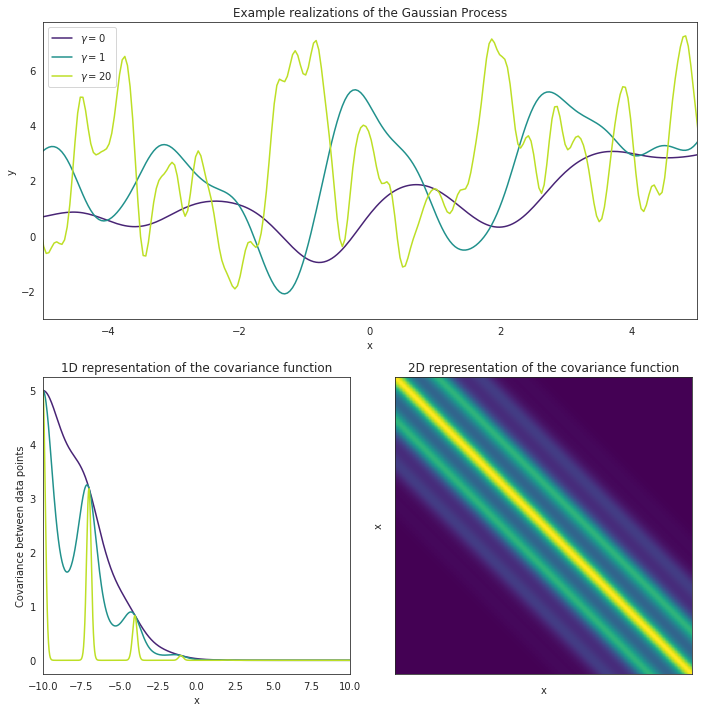

In [56]:
amp_1 = 1
metric = 10

amp_2 = 5.0
log_period = np.log(3.0)
gamma = [0.1, 1.0, 20.0]

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

x = np.linspace(-10, 10, 500)
for i, g in enumerate(gamma):
    k1 = amp_1 * kernels.ExpSquaredKernel(metric=metric)
    k2 = amp_2 * kernels.ExpSine2Kernel(gamma=g, log_period=log_period)
    kernel = k1*k2 #or k1*k2
    
    kernel_vals = kernel.get_value(np.atleast_2d(x).T)
    ax2.plot(x, kernel_vals[0],  color=sns.color_palette("viridis", 9)[4*i],
             label=r"$\gamma = %2.f$"%g)
    ax2.set_xlim(x[0], x[-1])
    if i == 1:
        ax3.imshow(kernel_vals, cmap="viridis", interpolation="nearest")
        ax3.set_xticklabels([])
        ax3.set_yticklabels([]);
        ax3.set_title("2D representation of the covariance function")
    
    np.random.seed(1234)
    gp = george.GP(kernel)
    gp.compute(x)
    y = gp.sample(size=1)

    ax1.plot(x, y.T+i, lw=1.5, alpha=1.0, color=sns.color_palette("viridis", 9)[4*i],
             label=r"$\gamma = %2.f$"%g)
    ax1.set_xlim(-5, 5);
    
    
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Example realizations of the Gaussian Process")
ax1.legend(loc=2)

ax2.set_xlabel("x")
ax2.set_ylabel("Covariance between data points")
ax2.set_title("1D representation of the covariance function")

ax3.set_xlabel("x")
ax3.set_ylabel("x")

plt.tight_layout()

This plot is a visualization of both kernels (specifically multiplied, not added). Although the effects are a little extreme in comparison to what we expect from our other data, we can see in the top figure that the lightcurve repeats and remains periodic, but gradually evolves over time. The correlation between the data points nearby are still periodic, but the expectation that such a pristine periodicity remains the same forever has been removed, which is exactly what we were hoping for. 

Now just to clarify, this doesn't mean that the kernel expects the lightcurve to stop being periodic as some point. It just means that the expectation for the lightcurve to return to exactly the same value every cycle has been lessened, meaning that the kernel is better able to fit lightcurves with data sets captured over longer time frames. Exciting stuff!

### Metric

Now just as before, I want to quickly clarify what the parameters attributed to this kernel mean. The **Metric** parameter is a bit like Gamma, in that is determines how fast the correlation between data points drops off. A larger metric value means a longer time before the correlation falls to 0, and vice versa.

### Amplitude (long)

The **Amplitude** here is attributed to how much the kernel varies over time. 

### NOTE!

In order to avoid any confusion with the previously-mentioned amplitude parameter, I will always refer to this amplitude as **amplitude (long)** since it is responsible for the long-term adaptations in the kernel, while the other amplitude is referred to as **amplitude (periodic)** since that amplitude determines the height of the periodic kernel. Hopefully this distinction should lessen any confusion in the future.

This is most of what I can offer as an explanation for the kernels. We use the package **george** to set all of this up. A lot of great and more technical documentation can be found over on the website for george (https://george.readthedocs.io/en/latest/)